# Shooting Method

Boundary-value problems are also ordinary differential equations—the difference is that our two constraints are at boundaries of the domain, rather than both being at the starting point.

For example, consider the ODE
\begin{equation}
y^{\prime\prime} + xy^{\prime} - xy = 2x
\end{equation}
with the boundary conditions $y(0)=1$ and $y(2)=8$.

The numerical methods we have already discussed (e.g., Forward Euler, Runge-Kutta) require values of $y$ and $y^{\prime}$ at the starting point, $x=0$. So we can't use these directly because we are missing $y^{\prime}(0)$. 

But, what if we could *guess* a value for the missing initial condition, then integrate towards the second boundary condition using one of our familiar numerical methods, and then adjust our guess if necessary and repeat? This concept is the **shooting method**.

The shooting method algorithm is:

1. Guess a value of the missing initial condition; in this case, that is $y'(0)$.
2. Integrate the ODE like an initial-value problem, using our existing numerical methods, to get the given boundary condition(s); in this case, that is $y(L)$.
3. Assuming your trial solution for $y(L)$ does not match the given boundary condition, adjust your guess for $y'(0)$ and repeat.

Now, this algorithm will not work particularly well if all your guesses are random/uninformed. Fortunately, we can use linear interpolation to inform a third guess based on two initial attempts:
\begin{align}
\text{guess 3} &= \text{guess 2} + m \left( \text{target} - \text{solution 2} \right) \\
m &= \frac{\text{guess 1} - \text{guess 2}}{\text{solution 1} - \text{solution 2}}
\end{align}
where "target" is the target boundary condition—in this case, $y(L)$.

## Example: linear ODE

Let's try solving the given ODE using the shooting method:
\begin{equation}
y^{\prime\prime} + xy^{\prime} - xy = 2x
\end{equation}
with the boundary conditions $y(0)=1$ and $y(2)=8$.

First, we need to convert this 2nd-order ODE into a system of two 1st-order ODEs, where we can define $u = y'$:
\begin{align}
y' &= u \\
u' &= 2x + xy - xu
\end{align}

In [1]:
%%file shooting_rhs.m
function dydx = shooting_rhs(x, y)

dydx = zeros(2,1);
dydx(1) = y(2);
dydx(2) = 2*x - x*y(2) + x*y(1);

Created file '/Users/niemeyek/projects/ME373-book/content/bvps/shooting_rhs.m'.


Solution 1:  6.00
Solution 2: 11.96
Guess 3:     2.01
Solution 3:  8.00
Target:      8.00


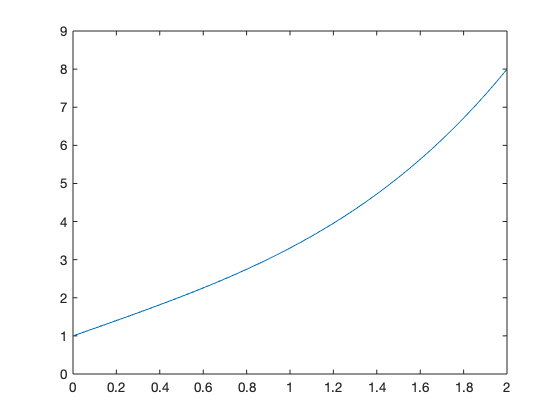

In [13]:
clear all; clc

% target boundary condition
target = 8;

% Pick a guess for y'(0) of 1
guess1 = 1;
[X, Y] = ode45('shooting_rhs', [0 2], [1 guess1]);
solution1= Y(end,1);
fprintf('Solution 1: %5.2f\n', solution1);

% Pick a second guess for y'(0) of 4
guess2 = 4;
[X, Y] = ode45('shooting_rhs', [0 2], [1 guess2]);
solution2 = Y(end,1);
fprintf('Solution 2: %5.2f\n', solution2);

% now use linear interpolation to find a new guess
m = (guess1 - guess2)/(solution1 - solution2);
guess3 = guess2 + m*(target-solution2);
fprintf('Guess 3:    %5.2f\n', guess3);

[X, Y] = ode45('shooting_rhs', [0 2], [1 guess3]);
solution3 = Y(end,1);
fprintf('Solution 3: %5.2f\n', solution3);
fprintf('Target:     %5.2f\n', target);

plot(X, Y(:,1)); axis([0 2 0 9])

As you can see, using linear interpolation, we are able to find the correct guess for the missing initial condition $y'(0)$ with in just three steps. This works so well because this is a *linear* ODE. If we had a nonlinear ODE, it would take more tries, as we'll see shortly.

## Example: nonlinear ODE

We can use the shooting method to solve a famous fluids problem: the [Blasius boundary layer](https://en.wikipedia.org/wiki/Blasius_boundary_layer).

<figure>
  <center>
  <img src="../images/boundary-layer.png" alt="Laminar boundary layer, from https://commons.wikimedia.org/wiki/File:Laminar_boundary_layer_scheme.svg" style="width: 400px;"/>
  <figcaption>Figure: Laminar boundary layer, taken from <a href="https://commons.wikimedia.org/wiki/File:Laminar_boundary_layer_scheme.svg">https://commons.wikimedia.org/wiki/File:Laminar_boundary_layer_scheme.svg</a></figcaption>
  </center>
</figure>

To get to a solveable ODE, we start with the conservation of momentum equation (i.e., Navier–Stokes equation) in the $x$-direction:
\begin{equation}
u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = \nu \frac{\partial^2 u}{\partial y^2}
\end{equation}
and the conservation of mass equation:
\begin{equation}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 \;,
\end{equation}
where $u$ is the velocity component in the $x$-direction, $v$ is the velocity component in the $y$-direction, and $\nu$ is the fluid's kinematic viscosity. The boundary conditions are that $u = v = 0$ at $y=0$, and that $u = U_{\infty}$ as $y \rightarrow \infty$, where $U_{\infty}$ is the free-stream velocity.

Blasius solved this problem by converting the PDE into an ODE, by recognizing that the boundary layer thickness is given by $\delta(x) \sim \sqrt{\frac{x \nu}{U_{\infty}}}$, and then nondimensionalizing the position coordinates using a similarity variable
\begin{equation}
\eta = y \sqrt{\frac{U_{\infty}}{2 \nu x}}
\end{equation}

By introducing the stream function, $\psi (x,y)$, we can ensure the continuity equation is satisfied:
\begin{equation}
u = \frac{\partial \psi}{\partial y} \;, \quad v = -\frac{\partial \psi}{\partial x}
\end{equation}

Let's check this, using SymPy:

In [1]:
%%python
import sympy as sym
sym.init_printing()
x, y, u, v = sym.symbols('x y u v')

# Streamfunction
psi = sym.Function(r'psi')(x,y)

# Define u and v based on the streamfunction
u = psi.diff(y)
v = -psi.diff(x)

# Check the continuity equation:
print(u.diff(x) + v.diff(y) == 0)

True


Using the boundary layer thickness and free-stream velocity, we can define the dimensionlesss stream function $f(\eta)$:
\begin{equation}
f(\eta) = \frac{\psi}{U_{\infty}} \sqrt{\frac{U_{\infty}}{2 \nu x}}
\end{equation}
which relates directly to the velocity components:
\begin{align}
u &= \frac{\partial \psi}{\partial y} = \frac{\partial \psi}{\partial f} \frac{\partial f}{\partial \eta} \frac{\partial \eta}{\partial y} \\
 &= U_{\infty} \sqrt{\frac{2 \nu x}{U_{\infty}}} \cdot f^{\prime}(\eta) \cdot \sqrt{\frac{U_{\infty}}{2 \nu x}} \\
u &= U_{\infty} f^{\prime} (\eta) \\
v &= -\frac{\partial \psi}{\partial x} = -\left( \frac{\partial \psi}{\partial x} + \frac{\partial \psi}{\partial \eta} \frac{\partial \eta}{\partial x} \right) \\
 &= \sqrt{\frac{\nu U_{\infty}}{2x}} \left( \eta f^{\prime} - f \right)
\end{align}

We can insert these into the $x$-momentum equation, which leads to an ODE for the dimensionless stream function $f(\eta)$:
\begin{equation}
f^{\prime\prime\prime} + f f^{\prime\prime} = 0 \;,
\end{equation}
with the boundary conditions $f = f^{\prime} = 0$ at $\eta = 0$, and $f^{\prime} = 1$ as $\eta \rightarrow \infty$.

This is a 3rd-order ODE, which we can solve by converting it into three 1st-order ODEs:
\begin{align}
y_1 &= f \quad y_1^{\prime} = y_2 \\
y_2 &= f^{\prime} \quad y_2^{\prime} = y_3 \\
y_3 &= f^{\prime\prime} \quad y_3^{\prime} = -y_1 y_3
\end{align}
and we can use the shooting method to solve by recognizing that we have two initial conditions, $y_1(0) = y_2(0) = 0$, and are missing $y_3(0)$. We also have a target boundary condition: $y_2(\infty) = 1$.

(Note: obviously we cannot truly integrate over $0 \leq \eta < \infty$. Instead, we just need to choose a large enough number. In this case, using 10 is sufficient.)

Let's create a function to evaluate the derivatives:

In [2]:
%%file blasius_rhs.m
function dydx = blasius_rhs(eta, y)

dydx = zeros(3,1);

dydx(1) = y(2);
dydx(2) = y(3);
dydx(3) = -y(1) * y(3);

Created file '/Users/niemeyek/projects/ME373-book/content/bvps/blasius_rhs.m'.


First, let's try the same three-step approach we used for the simpler example, taking two guesses and then using linear interpolation to find a third guess:

In [3]:
clear all; clc

target = 1.0;

guesses = zeros(3,1);
solutions = zeros(3,1);

guesses(1) = 1;
[eta, F] = ode45('blasius_rhs', [0 10], [0 0 guesses(1)]);
solutions(1) = F(end, 2);

guesses(2) = 0.1;
[eta, F] = ode45('blasius_rhs', [0 10], [0 0 guesses(2)]);
solutions(2) = F(end, 2);

m = (guesses(1) - guesses(2))/(solutions(1) - solutions(2));
guesses(3) = guesses(2) + m*(target - solutions(2));

[eta, F] = ode45('blasius_rhs', [0 10], [0 0 guesses(3)]);
solutions(3) = F(end, 2);

tries = [1; 2; 3];
table(tries, guesses, solutions)
fprintf('Target: %5.2f\n', target);


ans =

  3x3 table

    tries    guesses    solutions
    _____    _______    _________

      1            1     1.6553  
      2          0.1     0.3566  
      3      0.54587     1.1056  

Target:  1.00


So, for this problem, using linear interpolation did *not* get us the correct solution on the third try. This is because the ODE is nonlinear. But, you can see that we are converging towards the correct solution—it will just take more tries.

Rather than manually take an unknown (and potentially large) number of guesses, let's automate this with a `while` loop:

In [5]:
clear all; clc

target = 1.0;

% get these arrays of stored values started.
% note: I'm only doing this to make it easier to show a table of values
% at the end; otherwise, there's no need to store these values.
tries = [1; 2; 3];
guesses = zeros(3,1);
solutions = zeros(3,1);

guesses(1) = 1;
[eta, F] = ode45('blasius_rhs', [0 10], [0 0 guesses(1)]);
solutions(1) = F(end, 2);

guesses(2) = 0.1;
[eta, F] = ode45('blasius_rhs', [0 10], [0 0 guesses(2)]);
solutions(2) = F(end, 2);

num = 2;
solutions(3) = -1000.; % doing this to kick off the while loop
while abs(target - solutions(num)) > 1.e-9
    num = num + 1;
    m = (guesses(num-2) - guesses(num-1))/(solutions(num-2) - solutions(num-1));
    guesses(num) = guesses(num-1) + m*(target - solutions(num-1));
    [eta, F] = ode45('blasius_rhs', [0 1e3], [0 0 guesses(num)]);
    solutions(num) = F(end, 2);
    tries(num) = num;
    
    % we should probably set a maximum number of iterations, just to prevent
    % an infinite while loop in case something goes wrong
    if num >= 1e4
        break
    end
end

table(tries, guesses, solutions)
fprintf('Number of iterations required: %d', num)


ans =

  7x3 table

    tries    guesses    solutions
    _____    _______    _________

      1            1      1.6553 
      2          0.1      0.3566 
      3      0.54587      1.1056 
      4      0.48301       1.019 
      5      0.46922     0.99951 
      6      0.46957           1 
      7      0.46957           1 

Number of iterations required: 7

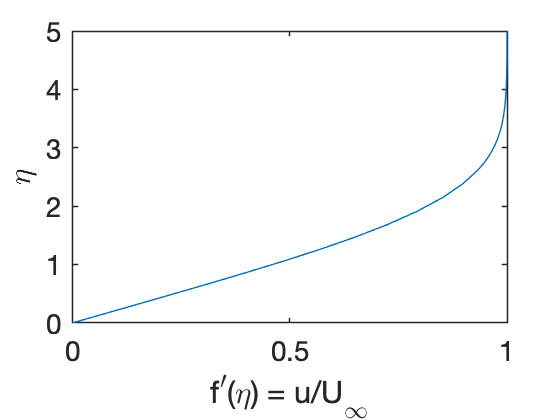

In [6]:
%plot -r 200
plot(F(:, 2), eta); ylim([0 5])
xlabel("f^{\prime}(\eta) = u/U_{\infty}")
ylabel('\eta')

We can see that this plot of $\eta$, the $y$ position normalized by the boundary-layer thickness, vs. nondimensional velocity matches the original figure.